# Task 4

The objective of this task is to find the lowest eigenvalue of the matrix: 
$$H = \begin{bmatrix}
0 & 0 & 0 & 0 \\ 
0 & -1 & 1 & 0 \\
0 & 1 & -1 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}$$
This will be done by considering it as a Hamiltonian and using Variational Quantum Eigensolver.

In [1]:
import numpy as np
from qiskit import *
from qiskit.tools.jupyter import *
import matplotlib.pyplot as plt
backend = BasicAer.get_backend('qasm_simulator')

## First classical check

We compute classically the eigenvalues and eigenvectors to check future results.

In [2]:
H = np.array([[0,0,0,0],
            [0,-1,1,0],
            [0,1,-1,0],
            [0,0,0,0]])
print(np.linalg.eig(H))

(array([ 0., -2.,  0.,  0.]), array([[ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.70710678,  0.70710678,  0.        ,  0.        ],
       [ 0.70710678, -0.70710678,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]))


We expect to find at the end -2, and the associated state is $\frac{|01\rangle - |10\rangle}{\sqrt{2}}$

## Decomposition of our hamiltonian

We decompose our hamiltonian as a sum of Pauli operators. For each operator, we will note $\sigma_x^i$, $\sigma_y^i$ and $\sigma_z^i$ the operators $\sigma_x$, $\sigma_y$ and $\sigma_z$ applied to the $i$ qubit. Here $i \in \{1,2\}$.

The code below shows that our operator can be decomposed as $$H = \frac{1}{2} (\sigma_z^1\sigma_z^2 + \sigma_y^1\sigma_y^2 + \sigma_x^1\sigma_x^2 - Id)$$

In [3]:
x1 = np.array([[0,0,1,0],
                [0,0,0,1],
                [1,0,0,0],
                [0,1,0,0]])
x2 = np.array([[0,1,0,0],
                [1,0,0,0],
                [0,0,0,1],
                [0,0,1,0]])
z1 = np.array([[1,0,0,0],
                [0,1,0,0],
                [0,0,-1,0],
                [0,0,0,1]])
z2 = np.array([[1,0,0,0],
                [0,-1,0,0],
                [0,0,1,0],
                [0,0,0,1]])

y1 = np.array([[0,0,-1j,0],
                [0,0,0,-1j],
                [1j,0,0,0],
                [0,1j,0,0]])
y2 = np.array([[0,-1j,0,0],
                [1j,0,0,0],
                [0,0,0,-1j],
                [0,0,1j,0]])
I = np.eye(4)
x1x2 = np.dot(x1,x2)
z1z2 = np.dot(z1,z2)
y1y2 = np.dot(y1,y2)

0.5 * (z1z2 + y1y2 + x1x2 -I)

array([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j,  1.+0.j,  0.+0.j],
       [ 0.+0.j,  1.+0.j, -1.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j]])

## Preparing the variational circuit

The goal of the circuit is to compute $E(\theta) = \langle \psi(\theta)|H|\psi(\theta) \rangle$ where $|\psi(\theta)\rangle$ is a parametered ansatz. Afterwards, we will find the $\theta$ that minimizes this quantity and it will be our upper bound for the lowest eigenvalue. For clarity of notation, we will omit the explicit dependency in $\theta$.

**How to do this ?**

$E$ can be decomposed as a sum of terms by the decomposition of the Hamiltonian. 
$$E = \frac{1}{2}(\langle \psi|\sigma_z^1\sigma_z^2|\psi \rangle + \langle \psi|\sigma_x^1\sigma_x^2|\psi \rangle + \langle \psi|\sigma_y^1\sigma_y^2|\psi \rangle - 1)$$

We will show that each term can be estimated by a quantum circuit.

Let us assume that $|\psi\rangle = a|00\rangle + b|01\rangle + c|10\rangle + d|11\rangle$. 

Then $\langle \psi|\sigma_z^1\sigma_z^2|\psi \rangle = (a^*\langle 00| + b^*\langle 01| + c^*\langle 10| + d^*\langle 11|)(a|00\rangle - b|01\rangle - c|10\rangle + d|11\rangle) = |a|^2 - |b|^2 - |c|^2 + |d|^2$ with $|a|^2, |b|^2, |c|^2, |d|^2$ that can be obtained by measurement in computational basis. Therefore, computing the first term only require to measure $|\psi\rangle$ in computational basis.

For the other terms, the same formula is valid, except the measurement has to be done on $R_y(-\pi/2)|\psi\rangle$ for $\sigma_x^1\sigma_x^2$ and on $R_y(\pi/2)|\psi\rangle$ for $\sigma_y^1\sigma_y^2$. Let us prove this result.

***Proof*** : If we consider one qubit, $R_y(\pi/2)|0\rangle = |+\rangle$ and $R_y(\pi/2)|0\rangle = |-\rangle$,  with $|+\rangle = \frac{|0\rangle+|1\rangle}{\sqrt{2}}$ and  $|-\rangle = \frac{|0\rangle-|1\rangle}{\sqrt{2}}$.
Furthermore $\sigma_x|+\rangle = |-\rangle$ and $\sigma_x|+\rangle = -|-\rangle$. $\sigma_x$ acts then like $\sigma_z$ in the $|+\rangle, |-\rangle$ basis. So if we note $ |\psi'\rangle = R_y(\pi/2)|\psi\rangle $, we have $\langle\psi'|\sigma_x|\psi'\rangle = \langle\psi|\sigma_z|\psi\rangle$. Therefore, by inverting the equation, if we note $|\psi''\rangle = R_y(-\pi/2)|\psi\rangle$, we have $\langle\psi''|\sigma_z|\psi''\rangle = \langle\psi|\sigma_x|\psi\rangle$. The proof is the same for $\sigma_y$.

### The ansatz circuit

The parameter for the ansatz is the angle in the $R_z$ rotation.

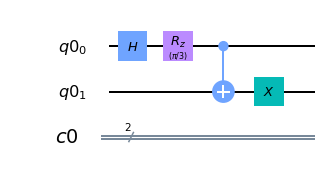

In [4]:
q       = QuantumRegister(2)
c       = ClassicalRegister(2)
circuit = QuantumCircuit(q,c)
circuit.h(0)
circuit.rz(np.pi/3,0)
circuit.cx(0,1)
circuit.x(1)
circuit.draw(output='mpl')

The following function apply the ansatz with parameter $\theta$ to a circuit passed in arguments.

In [5]:
def ansatz(theta, circuit):
    circuit.h(0)
    circuit.rz(theta,0)
    circuit.cx(0,1)
    circuit.x(1)
    return circuit

These functions compute each term of our energy.

In [6]:
def expz1z2(theta, shots=1000):
    '''Returns <ansatz(theta)|sigma_z|ansatz(theta)>'''
    q       = QuantumRegister(2)
    c       = ClassicalRegister(2)
    circuit = QuantumCircuit(q,c)
    circuit = ansatz(theta, circuit)
    circuit.measure(0,c[0])
    circuit.measure(1,c[1])
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(4)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return result[0] - result[1] - result[2] + result[3]

def expx1x2(theta, shots=1000):
    '''Returns <ansatz(theta)|sigma_x|ansatz(theta)>'''
    q       = QuantumRegister(2)
    c       = ClassicalRegister(2)
    circuit = QuantumCircuit(q,c)
    circuit = ansatz(theta, circuit)
    circuit.ry(-np.pi/2, 0)
    circuit.ry(-np.pi/2, 1)
    circuit.measure(0,c[0])
    circuit.measure(1,c[1])
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(4)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return result[0] - result[1] - result[2] + result[3]

def expy1y2(theta, shots=1000):
    '''Returns <ansatz(theta)|sigma_y|ansatz(theta)>'''
    q       = QuantumRegister(2)
    c       = ClassicalRegister(2)
    circuit = QuantumCircuit(q,c)
    circuit = ansatz(theta, circuit)
    circuit.ry(np.pi/2, 0)
    circuit.ry(np.pi/2, 1)
    circuit.measure(0,c[0])
    circuit.measure(1,c[1])
    result = execute(circuit,backend,shots=shots).result()
    counts = result.get_counts(circuit)
    result=np.zeros(4)
    for key in counts:
        result[int(key,2)]=counts[key]
    result/=shots
    return result[0] - result[1] - result[2] + result[3]


Our final energy.

In [7]:
def energy(theta):
    return (expy1y2(theta, shots=10000) + expx1x2(theta, shots=10000) + expz1z2(theta, shots=10000) - 1) * 0.5


We will now compute the energy for different values of $\theta$ and look empirically at the minimum.

In [8]:
X = np.linspace(-2*np.pi, 2*np.pi, 100)
Y = np.zeros_like(X)

for i in range(len(X)):
    Y[i] = energy(X[i])

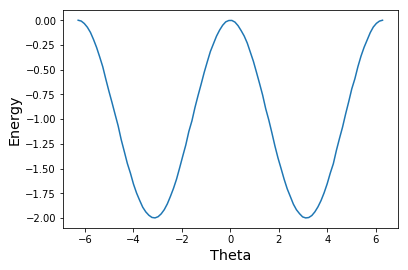

In [9]:
plt.plot(X,Y)
plt.xlabel("Theta", fontsize='x-large')
plt.ylabel("Energy", fontsize='x-large')
plt.show()

The minimum value of this function is -2, and is reached for $\theta = \pi$. It can be shown that putting $\theta = \pi$ in the ansatz formula leads to the state $\frac{|01\rangle - |10\rangle}{\sqrt{2}}$. Everything is coherent with the results of the very beginning. 

**We are lucky in this case because the state of lowest energy is attained. Had not it be the case, we only proved that the lowest eigenvalue is smaller than -2.**

### Final result : -2